In [1]:
from itertools import product

import z3
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
z3.set_option(html_mode=False)

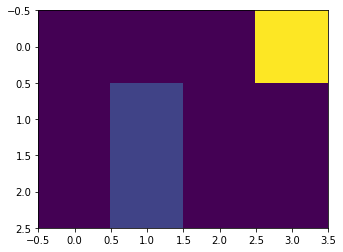

In [2]:
layout = np.array([
    [0,0,0,5],
    [0,1,0,0],
    [0,1,0,0],
])
# layout = np.array([
#     [0,5],
#     [0,0],
# ])
plt.imshow(layout)

### Layout encoding (facts):
1. for each empty cell(i,j): $cell(i, j).$
2. $goal(0, 3).$
3. $block(1, 1). block(2, 1).$

In [3]:
axiom_layout = []
cell = z3.Function('Cell', z3.IntSort(), z3.IntSort(), z3.BoolSort())
block = z3.Function('Block', z3.IntSort(), z3.IntSort(), z3.BoolSort())
goal = z3.Function('Goal', z3.IntSort(), z3.IntSort(), z3.BoolSort())
for i in range(layout.shape[0]):
    for j in range(layout.shape[1]):
        if layout[i, j] == 1:
            axiom_layout.append(block(i, j))
        else:
            axiom_layout.append(cell(i,j))
        if layout[i, j] > 1:
            axiom_layout.append(goal(i, j))
        else:
            axiom_layout.append(z3.Not(goal(i, j)))

i, j = z3.Ints('i j')
ij_range = z3.And(i >= 0, i < layout.shape[0], j >= 0, j < layout.shape[1])
# axiom_layout.append(z3.ForAll([i, j], cell(i, j) == z3.Not(block(i,j))))
axiom_layout.append(z3.ForAll([i, j], z3.Xor(cell(i, j), block(i, j)))) # Wang
axiom_layout.append(z3.ForAll([i, j], z3.Implies(z3.Or(i>=layout.shape[0], i<0, j>=layout.shape[1], j<0), block(i,j))))
axiom_layout

[Cell(0, 0),
 Not(Goal(0, 0)),
 Cell(0, 1),
 Not(Goal(0, 1)),
 Cell(0, 2),
 Not(Goal(0, 2)),
 Cell(0, 3),
 Goal(0, 3),
 Cell(1, 0),
 Not(Goal(1, 0)),
 Block(1, 1),
 Not(Goal(1, 1)),
 Cell(1, 2),
 Not(Goal(1, 2)),
 Cell(1, 3),
 Not(Goal(1, 3)),
 Cell(2, 0),
 Not(Goal(2, 0)),
 Block(2, 1),
 Not(Goal(2, 1)),
 Cell(2, 2),
 Not(Goal(2, 2)),
 Cell(2, 3),
 Not(Goal(2, 3)),
 ForAll([i, j], Xor(Cell(i, j), Block(i, j))),
 ForAll([i, j],
        Implies(Or(i >= 3, i < 0, j >= 4, j < 0),
                Block(i, j)))]

In [4]:
# actions = ['stop', 'up', 'down', 'left', 'right']
# Action = z3.Datatype('Action')
# for a in actions:
#     Action.declare(a)
# Action = Action.create()
Action, (stop, up, down, left, right) = z3.EnumSort('Action', ('stop', 'up', 'down', 'left', 'right'))

### Available action encoding:

- $\forall i,j. cell(i, j) \land cell(i + 1, j) \equiv avai\_action(i, j, down)$

similarly for stop, up, right, left

In [5]:
axiom_avai_actions = []
avai_action = z3.Function('Avai_Action', z3.IntSort(), z3.IntSort(), Action, z3.BoolSort())
axiom_avai_actions.append(
    z3.ForAll([i, j], z3.Implies(ij_range, z3.And(cell(i, j), cell(i, j)) == avai_action(i, j, stop)))
)
axiom_avai_actions.append(
    z3.ForAll([i, j], z3.Implies(ij_range, z3.And(cell(i, j), cell(i + 1, j)) == avai_action(i, j, down)))
)
axiom_avai_actions.append(
    z3.ForAll([i, j], z3.Implies(ij_range, z3.And(cell(i, j), cell(i - 1, j)) == avai_action(i, j, up)))
)
axiom_avai_actions.append(
    z3.ForAll([i, j], z3.Implies(ij_range, z3.And(cell(i, j), cell(i, j + 1)) == avai_action(i, j, right)))
)
axiom_avai_actions.append(
    z3.ForAll([i, j], z3.Implies(ij_range, z3.And(cell(i, j), cell(i, j - 1)) == avai_action(i, j, left)))
)
axiom_avai_actions

[ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                And(Cell(i, j), Cell(i, j)) ==
                Avai_Action(i, j, stop))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                And(Cell(i, j), Cell(i + 1, j)) ==
                Avai_Action(i, j, down))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                And(Cell(i, j), Cell(i - 1, j)) ==
                Avai_Action(i, j, up))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                And(Cell(i, j), Cell(i, j + 1)) ==
                Avai_Action(i, j, right))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                And(Cell(i, j), Cell(i, j - 1)) ==
                Avai_Action(i, j, left)))]

### Movement encoding:

- $\forall i,j,i',j'. move(i,j,down,i'j') \equiv cell(i,j)\land i'==i+1 \land j'==j \land cell(i+1, j)$

In [6]:
axiom_move = []
move = z3.Function('Move', z3.IntSort(), z3.IntSort(), Action, z3.IntSort(), z3.IntSort(), z3.BoolSort())
i_, j_ = z3.Ints("i' j'")
ij__range = z3.And(i_ >= 0, i_ < layout.shape[0], j_ >= 0, j_ < layout.shape[1])
all_range = z3.And(ij_range, ij__range)
axiom_move.append(
    z3.ForAll([i, j, i_, j_], z3.Implies(all_range, move(i, j, stop, i_, j_) ==
              z3.And(cell(i, j), i_ == i, j_ == j, cell(i, j))))
)
axiom_move.append(
    z3.ForAll([i, j, i_, j_], z3.Implies(all_range, move(i, j, down, i_, j_) ==
              z3.And(cell(i, j), i_ == i + 1, j_ == j, cell(i + 1, j))))
)
axiom_move.append(
    z3.ForAll([i, j, i_, j_], z3.Implies(all_range, move(i, j, up, i_, j_) ==
              z3.And(cell(i, j), i_ == i - 1, j_ == j, cell(i - 1, j))))
)
axiom_move.append(
    z3.ForAll([i, j, i_, j_], z3.Implies(all_range, move(i, j, right, i_, j_) ==
              z3.And(cell(i, j), i_ == i, j_ == j + 1, cell(i, j + 1))))
)
axiom_move.append(
    z3.ForAll([i, j, i_, j_], z3.Implies(all_range, move(i, j, left, i_, j_) == 
              z3.And(cell(i, j), i_ == i, j_ == j - 1, cell(i, j - 1))))
)
axiom_move

[ForAll([i, j, i', j'],
        Implies(And(And(i >= 0, i < 3, j >= 0, j < 4),
                    And(i' >= 0, i' < 3, j' >= 0, j' < 4)),
                Move(i, j, stop, i', j') ==
                And(Cell(i, j), i' == i, j' == j, Cell(i, j)))),
 ForAll([i, j, i', j'],
        Implies(And(And(i >= 0, i < 3, j >= 0, j < 4),
                    And(i' >= 0, i' < 3, j' >= 0, j' < 4)),
                Move(i, j, down, i', j') ==
                And(Cell(i, j),
                    i' == i + 1,
                    j' == j,
                    Cell(i + 1, j)))),
 ForAll([i, j, i', j'],
        Implies(And(And(i >= 0, i < 3, j >= 0, j < 4),
                    And(i' >= 0, i' < 3, j' >= 0, j' < 4)),
                Move(i, j, up, i', j') ==
                And(Cell(i, j),
                    i' == i - 1,
                    j' == j,
                    Cell(i - 1, j)))),
 ForAll([i, j, i', j'],
        Implies(And(And(i >= 0, i < 3, j >= 0, j < 4),
                    And(i' >= 0, i' < 3, j'

### Policy encoding:

1. $\forall i,j,a. policy(i,j,a) \implies cell(i,j) \land avai\_action(i,j,a)$
2. $\forall i,j. cell(i,j) \implies one\_true\{policy(i,j,a) \text{ for a in actions}\}$

In [7]:
axiom_policy = []
policy = z3.Function('Policy', z3.IntSort(), z3.IntSort(), Action, z3.BoolSort())
a = z3.Const('a', Action)
axiom_policy.append(
    z3.ForAll([i, j, a], z3.Implies(policy(i, j, a), z3.And(cell(i, j), avai_action(i, j, a))))
)
actions = (stop, up, down, left, right)
axiom_policy.append(
    z3.ForAll([i, j],
              z3.Implies(z3.And(ij_range, cell(i, j)),
                  z3.PbEq([(policy(i, j, action), 1) for action in actions], 1)
              )
    )
)
axiom_policy.append(
    z3.ForAll([i, j, a],
              z3.Implies(z3.Or(i>=layout.shape[0], i<0, j>=layout.shape[1], j<0),
                         z3.Implies(policy(i, j, a), False)
              )
    )
)
axiom_policy

[ForAll([i, j, a],
        Implies(Policy(i, j, a),
                And(Cell(i, j), Avai_Action(i, j, a)))),
 ForAll([i, j],
        Implies(And(And(i >= 0, i < 3, j >= 0, j < 4),
                    Cell(i, j)),
                PbEq(((Policy(i, j, stop), 1),
                      (Policy(i, j, up), 1),
                      (Policy(i, j, down), 1),
                      (Policy(i, j, left), 1),
                      (Policy(i, j, right), 1)),
                     1))),
 ForAll([i, j, a],
        Implies(Or(i >= 3, i < 0, j >= 4, j < 0),
                Implies(Policy(i, j, a), False)))]

### Reachability encoding:

1. $\forall i,j. goal(i,j) \implies policy(i,j,stop)$
2. $\forall i,j. goal(i,j) \equiv reachable(0,i,j)$
3. For each k <= MAX,
   $\forall i,j. 
        reachable(k, i,j) \equiv reachable(k-1, i,j) \lor
        \{\exists i',j',a. reachable(k-1, i', j') \land policy(i,j,a) \land move(i,j,a,i',j')\}$
4. $\forall i,j. cell(i,j) \implies reachable(MAX, i,j)$

In [8]:
MAX = 7
axiom_reachable = []
reachable = z3.Function('Reachable', z3.IntSort(), z3.IntSort(), z3.IntSort(), z3.BoolSort())
axiom_reachable.append(
    z3.ForAll([i, j], reachable(0, i, j) == goal(i, j))
)
axiom_reachable.append(
    z3.ForAll([i, j], z3.Implies(goal(i, j), policy(i, j, stop)))
)

for k in range(1, MAX):
    axiom_reachable.append(
        z3.ForAll([i, j],z3.Implies(ij_range,
                  reachable(k, i, j) ==
                  z3.Or(reachable(k - 1, i, j),
                        z3.Exists(
                            [i_, j_, a],
                            z3.And(cell(i_, j_), reachable(k - 1, i_, j_), policy(i, j, a), move(i, j, a, i_, j_))
                        ) 
                  )  
        ))
          
    )
axiom_reachable.append(
    z3.ForAll([i, j], z3.Implies(cell(i, j), reachable(k, i, j)))
)
axiom_reachable

[ForAll([i, j], Reachable(0, i, j) == Goal(i, j)),
 ForAll([i, j], Implies(Goal(i, j), Policy(i, j, stop))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                Reachable(1, i, j) ==
                Or(Reachable(0, i, j),
                   Exists([i', j', a],
                          And(Cell(i', j'),
                              Reachable(0, i', j'),
                              Policy(i, j, a),
                              Move(i, j, a, i', j')))))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                Reachable(2, i, j) ==
                Or(Reachable(1, i, j),
                   Exists([i', j', a],
                          And(Cell(i', j'),
                              Reachable(1, i', j'),
                              Policy(i, j, a),
                              Move(i, j, a, i', j')))))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                Reachable(3, i, j) ==
                Or

In [9]:
solver = z3.Solver()
solver.add(axiom_layout)
solver

[Cell(0, 0),
 Not(Goal(0, 0)),
 Cell(0, 1),
 Not(Goal(0, 1)),
 Cell(0, 2),
 Not(Goal(0, 2)),
 Cell(0, 3),
 Goal(0, 3),
 Cell(1, 0),
 Not(Goal(1, 0)),
 Block(1, 1),
 Not(Goal(1, 1)),
 Cell(1, 2),
 Not(Goal(1, 2)),
 Cell(1, 3),
 Not(Goal(1, 3)),
 Cell(2, 0),
 Not(Goal(2, 0)),
 Block(2, 1),
 Not(Goal(2, 1)),
 Cell(2, 2),
 Not(Goal(2, 2)),
 Cell(2, 3),
 Not(Goal(2, 3)),
 ForAll([i, j], Xor(Cell(i, j), Block(i, j))),
 ForAll([i, j],
        Implies(Or(i >= 3, i < 0, j >= 4, j < 0),
                Block(i, j)))]

In [10]:
if solver.check() == z3.sat:
    m = solver.model()
    Cell = np.full(layout.shape, True)
    Goal = np.full(layout.shape, True)
    Block = np.full(layout.shape, True)
    for i in range(layout.shape[0]):
        for j in range(layout.shape[1]):
            Cell[i, j] = m.evaluate(cell(i, j))
            Goal[i, j] = m.evaluate(goal(i, j))
            Block[i, j] = m.evaluate(block(i, j))
    print('Cell\n', Cell)
    print('Goal\n', Goal)
    print('Block\n', Block)

Cell
 [[ True  True  True  True]
 [ True False  True  True]
 [ True False  True  True]]
Goal
 [[False False False  True]
 [False False False False]
 [False False False False]]
Block
 [[False False False False]
 [False  True False False]
 [False  True False False]]


In [11]:
solver.add(axiom_avai_actions)
solver
res = solver.check()

In [12]:
if res == z3.sat:
    m = solver.model()
    for i in range(layout.shape[0]):
        for j in range(layout.shape[1]):
            for a in actions:
                print(f'cell({i},{j}): action {a} {m.evaluate(avai_action(i, j, a))}')

cell(0,0): action stop True
cell(0,0): action up False
cell(0,0): action down True
cell(0,0): action left False
cell(0,0): action right True
cell(0,1): action stop True
cell(0,1): action up False
cell(0,1): action down False
cell(0,1): action left True
cell(0,1): action right True
cell(0,2): action stop True
cell(0,2): action up False
cell(0,2): action down True
cell(0,2): action left True
cell(0,2): action right True
cell(0,3): action stop True
cell(0,3): action up False
cell(0,3): action down True
cell(0,3): action left True
cell(0,3): action right False
cell(1,0): action stop True
cell(1,0): action up True
cell(1,0): action down True
cell(1,0): action left False
cell(1,0): action right False
cell(1,1): action stop False
cell(1,1): action up False
cell(1,1): action down False
cell(1,1): action left False
cell(1,1): action right False
cell(1,2): action stop True
cell(1,2): action up True
cell(1,2): action down True
cell(1,2): action left False
cell(1,2): action right True
cell(1,3): a

In [13]:
solver.add(axiom_move)
solver

[Cell(0, 0),
 Not(Goal(0, 0)),
 Cell(0, 1),
 Not(Goal(0, 1)),
 Cell(0, 2),
 Not(Goal(0, 2)),
 Cell(0, 3),
 Goal(0, 3),
 Cell(1, 0),
 Not(Goal(1, 0)),
 Block(1, 1),
 Not(Goal(1, 1)),
 Cell(1, 2),
 Not(Goal(1, 2)),
 Cell(1, 3),
 Not(Goal(1, 3)),
 Cell(2, 0),
 Not(Goal(2, 0)),
 Block(2, 1),
 Not(Goal(2, 1)),
 Cell(2, 2),
 Not(Goal(2, 2)),
 Cell(2, 3),
 Not(Goal(2, 3)),
 ForAll([i, j], Xor(Cell(i, j), Block(i, j))),
 ForAll([i, j],
        Implies(Or(i >= 3, i < 0, j >= 4, j < 0),
                Block(i, j))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                And(Cell(i, j), Cell(i, j)) ==
                Avai_Action(i, j, stop))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                And(Cell(i, j), Cell(i + 1, j)) ==
                Avai_Action(i, j, down))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                And(Cell(i, j), Cell(i - 1, j)) ==
                Avai_Action(i, j, up))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                And(Cell(i, j), Cell(i, j + 1)) ==
                Avai_Action(i, j, right))),
 ForAll([i, j],
        Implies(And(i >= 0, i < 3, j >= 0, j < 4),
                And(Cell(i, j), Cell(i, j - 1)) ==
                Avai_Action(i, j, left))),
 ForAll([i, j, i', j'],
        Implies(And(And(i >= 0, i < 3, j >= 0, j < 4),
                    And(i' >= 0, i' < 3, j' >= 0, j' < 4)),
                Move(i, j, stop, i', j') ==
                And(Cell(i, j),
                    i' == i,
                    j' == j,
                    Cell(i, j)))),
 ForAll([i, j, i', j'],
        Implies(And(And(i >= 0, i < 3, j >= 0, j < 4),
                    And(i' >= 0, i' < 3, j' >= 0, j' < 4)),
                Move(i, j, down, i', j') ==
                And(Cell(i, j),
                    i' == i + 1,
                    j' == j,
                    Cell(i + 1, j)))),
 ForAll([i, j, i', j'],
        Implies(And(And(i >= 0, i < 3, j >= 0, j < 4),
                    And(i' >= 0, i' < 3, j' >= 0, j' < 4)),
                Move(i, j, up, i', j') ==
                And(Cell(i, j),
                    i' == i - 1,
                    j' == j,
                    Cell(i - 1, j)))),
 ForAll([i, j, i', j'],
        Implies(And(And(i >= 0, i < 3, j >= 0, j < 4),
                    And(i' >= 0, i' < 3, j' >= 0, j' < 4)),
                Move(i, j, right, i', j') ==
                And(Cell(i, j),
                    i' == i,
                    j' == j + 1,
                    Cell(i, j + 1)))),
 ForAll([i, j, i', j'],
        Implies(And(And(i >= 0, i < 3, j >= 0, j < 4),
                    And(i' >= 0, i' < 3, j' >= 0, j' < 4)),
                Move(i, j, left, i', j') ==
                And(Cell(i, j),
                    i' == i,
                    j' == j - 1,
                    Cell(i, j - 1))))]

In [14]:
if solver.check() == z3.sat:
    m = solver.model()
    for i in range(layout.shape[0]):
        for j in range(layout.shape[1]):
            print(f'cell({i},{j}):')
            for a in actions:
                for i_ in range(layout.shape[0]):
                    for j_ in range(layout.shape[1]):
                        if m.evaluate(move(i,j,a,i_,j_)):
                            print(f'\t{a}\t to ({i_,j_})')

cell(0,0):
	stop	 to ((0, 0))
	down	 to ((1, 0))
	right	 to ((0, 1))
cell(0,1):
	stop	 to ((0, 1))
	left	 to ((0, 0))
	right	 to ((0, 2))
cell(0,2):
	stop	 to ((0, 2))
	down	 to ((1, 2))
	left	 to ((0, 1))
	right	 to ((0, 3))
cell(0,3):
	stop	 to ((0, 3))
	down	 to ((1, 3))
	left	 to ((0, 2))
cell(1,0):
	stop	 to ((1, 0))
	up	 to ((0, 0))
	down	 to ((2, 0))
cell(1,1):
cell(1,2):
	stop	 to ((1, 2))
	up	 to ((0, 2))
	down	 to ((2, 2))
	right	 to ((1, 3))
cell(1,3):
	stop	 to ((1, 3))
	up	 to ((0, 3))
	down	 to ((2, 3))
	left	 to ((1, 2))
cell(2,0):
	stop	 to ((2, 0))
	up	 to ((1, 0))
cell(2,1):
cell(2,2):
	stop	 to ((2, 2))
	up	 to ((1, 2))
	right	 to ((2, 3))
cell(2,3):
	stop	 to ((2, 3))
	up	 to ((1, 3))
	left	 to ((2, 2))


In [15]:
solver.add(axiom_policy + axiom_reachable)
# solver
res = solver.check()
res

sat

In [16]:
%%time
if res == z3.sat:
    m = solver.model()
    for i in range(layout.shape[0]):
        for j in range(layout.shape[1]):
            for a in actions:
                if m.evaluate(policy(i, j, a)):
                    print(f'cell{i, j} do {a}')

cell(0, 0) do right
cell(0, 1) do right
cell(0, 2) do right
cell(0, 3) do stop
cell(1, 0) do up
cell(1, 2) do up
cell(1, 3) do down
cell(2, 0) do up
cell(2, 2) do up
cell(2, 3) do left
CPU times: user 2.24 s, sys: 29.1 ms, total: 2.27 s
Wall time: 2.28 s


In [17]:
m = solver.model()
for i in range(layout.shape[0]):
    for j in range(layout.shape[1]):
        for k in range(6):
            if m.evaluate(reachable(k, i, j)):
                print(f'cell{i, j} can reach goal within {k} steps')

cell(0, 0) can reach goal within 3 steps
cell(0, 0) can reach goal within 4 steps
cell(0, 0) can reach goal within 5 steps
cell(0, 1) can reach goal within 2 steps
cell(0, 1) can reach goal within 3 steps
cell(0, 1) can reach goal within 4 steps
cell(0, 1) can reach goal within 5 steps
cell(0, 2) can reach goal within 1 steps
cell(0, 2) can reach goal within 2 steps
cell(0, 2) can reach goal within 3 steps
cell(0, 2) can reach goal within 4 steps
cell(0, 2) can reach goal within 5 steps
cell(0, 3) can reach goal within 0 steps
cell(0, 3) can reach goal within 1 steps
cell(0, 3) can reach goal within 2 steps
cell(0, 3) can reach goal within 3 steps
cell(0, 3) can reach goal within 4 steps
cell(0, 3) can reach goal within 5 steps
cell(1, 0) can reach goal within 4 steps
cell(1, 0) can reach goal within 5 steps
cell(1, 2) can reach goal within 2 steps
cell(1, 2) can reach goal within 3 steps
cell(1, 2) can reach goal within 4 steps
cell(1, 2) can reach goal within 5 steps
cell(1, 3) can r

In [18]:
m = solver.model()
for i in range(layout.shape[0]):
    for j in range(layout.shape[1]):
        for a in actions:
            if m.evaluate(policy(i, j, a)):
                print(f'cell{i, j} do {a}')

cell(0, 0) do right
cell(0, 1) do right
cell(0, 2) do right
cell(0, 3) do stop
cell(1, 0) do up
cell(1, 2) do up
cell(1, 3) do down
cell(2, 0) do up
cell(2, 2) do up
cell(2, 3) do left
